COCO_50.zip (50 sample for each one of the two classes I used in the research "Zebra & Giraffe"):


https://drive.google.com/file/d/1_g1yMXFhHRK9EGr17tFs8a3XSMON34oZ/view

ResNet18_SketchClassifier.pth:


https://drive.google.com/file/d/1VEatovqShP_QbniU1_4sM0R39StUdbWZ/view

SketchClassifier.pth:


https://drive.google.com/file/d/14mgO-xok8IdBoEn_j4_cljKtiDPw9-cH/view

pretrained.zip (PhotoSketch model):

https://drive.google.com/file/d/1TQf-LyS8rRDDapdcTnEgWzYJllPgiXdj/view

In case "cuda out of memory", you can run this cell so restart the session while keeping the files and installed libraries:

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

Just to avoid annoying warnings to focus on the output

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Get Dataset

In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content
!mkdir zip
%cd zip
!wget https://www.7-zip.org/a/7z2301-linux-x64.tar.xz
!tar -xf 7z2301-linux-x64.tar.xz
%cd ..

/content
/content/zip
--2025-09-14 12:12:59--  https://www.7-zip.org/a/7z2301-linux-x64.tar.xz
Resolving www.7-zip.org (www.7-zip.org)... 49.12.202.237
Connecting to www.7-zip.org (www.7-zip.org)|49.12.202.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1527700 (1.5M) [application/octet-stream]
Saving to: ‘7z2301-linux-x64.tar.xz’

7z2301-linux-x64.ta 100%[===================>]   1.46M  2.00MB/s    in 0.7s    

2025-09-14 12:13:01 (2.00 MB/s) - ‘7z2301-linux-x64.tar.xz’ saved [1527700/1527700]

/content


In [4]:
!/content/zip/7zz x "/content/drive/MyDrive/COCO_50.zip" -o"/content" -y


7-Zip (z) 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20
 64-bit locale=en_US.UTF-8 Threads:2 OPEN_MAX:1048576, ASM

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 10424099 bytes (10180 KiB)

Extracting archive: /content/drive/MyDrive/COCO_50.zip
--
Path = /content/drive/MyDrive/COCO_50.zip
Type = zip
Physical Size = 10424099

  0%    Everything is Ok

Folders: 13
Files: 400
Size:       11652329
Compressed: 10424099


# Dataset Class

In [5]:
import os
from glob import glob
from torch.utils.data import Dataset
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, data_root="/content/COCO_50", classes = ["giraffe", "zebra"], transform=None):
        self.data_root = data_root
        self.classes = classes

        self.image_paths, self.edge_paths, self.sketch_paths = [], [], []

        for cls in classes:
            img_dir = os.path.join(data_root, "image", cls)
            edge_dir = os.path.join(data_root, "edge", cls)
            sketch_dir = os.path.join(data_root, "sketch", cls)

            for img_path in glob(os.path.join(img_dir, "*.png")):
                filename = os.path.basename(img_path)
                edge_path = os.path.join(edge_dir, filename)
                sketch_path = os.path.join(sketch_dir, filename)

                self.image_paths.append(img_path)
                self.edge_paths.append(edge_path)
                self.sketch_paths.append(sketch_path)

        self.transform = transform

        self.prompts = {"zebra": "a zebra in an empty savanna, dry grass plains, no trees, clear sky, minimalist nature, photorealistic", "giraffe" : "a giraffe in an open barren plain, flat dry land, no vegetation, soft sunlight, isolated wildlife, high detail"}

    def __len__(self):
        return len(self.image_paths)

    def get_sketch(self, idx):
      return Image.open(self.sketch_paths[idx])

    def get_target_image(self, idx):
      return Image.open(self.image_paths[idx])

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        edge = Image.open(self.edge_paths[idx])
        sketch = Image.open(self.sketch_paths[idx])

        if self.transform:
            image = self.transform(image)
            edge = self.transform(edge)
            sketch = self.transform(sketch)

        class_name = os.path.basename(os.path.dirname(self.image_paths[idx]))

        prompt = self.prompts[class_name]

        return image, edge, sketch, prompt

In [ ]:
from torchvision.transforms import ToTensor

transform = ToTensor()
dataset = CustomDataset(transform=transform)

# print(len(dataset))
# image, edge, sketch, prompt = dataset[44]
# print(prompt)
# print(image.shape)
# print(edge.shape)
# print(sketch.shape)

# Models

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.skip_conv(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.resblock = ResBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x_res = self.resblock(x)
        p = self.pool(x_res)
        return x_res, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.resblock = ResBlock(out_channels*2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.resblock(x)
        return x


class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        q = self.query(x).view(B, -1, H*W)
        k = self.key(x).view(B, -1, H*W)
        v = self.value(x).view(B, C, H*W)
        attn = torch.softmax(torch.bmm(q.transpose(1,2), k), dim=-1)
        out = torch.bmm(v, attn).view(B, C, H, W)
        return self.gamma*out + x


class ResLEPUNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers=4, use_attention=True):
        super().__init__()
        self.num_layers = num_layers
        self.use_attention = use_attention


        self.e1 = EncoderBlock(in_channels, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)


        self.b = ResBlock(512, 1024)
        if self.use_attention:
            self.attn = SelfAttention(1024)


        self.d1 = DecoderBlock(1024, 512)
        self.d2 = DecoderBlock(512, 256)
        self.d3 = DecoderBlock(256, 128)
        self.d4 = DecoderBlock(128, 64)


        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, t):

        pos_elem = [torch.sin(2 * math.pi * t * (2 ** -l)) for l in range(self.num_layers)]
        pos_encoding = torch.cat(pos_elem, dim=1)
        x = torch.cat([x, t, pos_encoding], dim=1)


        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)


        b = self.b(p4)
        if self.use_attention:
            b = self.attn(b)


        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)


        out = self.out_conv(d4)
        return out.to(torch.float16)

In [ ]:
%%capture
!pip install einops
!pip install torch torchvision torchaudio diffusers matplotlib pillow numpy

In [ ]:
%%capture
from torchvision import models
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# ResNet18_SketchClassifier
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)

model.load_state_dict(torch.load("/content/drive/MyDrive/ResNet18_SketchClassifier.pth"))
model.to(device)
model.eval()

# # SketchClassifier
# model = SketchClassifier(num_classes=2)
# model.load_state_dict(torch.load("/content/drive/MyDrive/SketchClassifier.pth"))
# model.to(device)
# model.eval()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict_new_sketch(model, sketch, transform, classes, device='cuda'):

    sketch = transform(sketch).unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        outputs = model(sketch)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, preds = torch.max(probabilities, 1)

    predicted_class = classes[preds.item()]
    confidence = confidence.item()

    return predicted_class, confidence

# Training

In [ ]:
%%capture

import os

from einops import rearrange
import numpy as np
import torch
from tqdm import tqdm
from transformers import CLIPTokenizer
import typer
from typing_extensions import Annotated

import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image
import gc
from diffusers import StableDiffusionPipeline, DDIMScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

noise_scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    clip_sample=False,
)


pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
pipe = pipe.to(dtype=dtype)
vae, unet = pipe.vae.to(device), pipe.unet.to(device)

In [ ]:
def hook_unet(unet):
    blocks_idx = [0, 1, 2]
    feature_blocks = []
    def hook(module, input, output):
        if isinstance(output, tuple):
            output = output[0]

        if isinstance(output, torch.TensorType):
            feature = output.float()
            setattr(module, "output", feature)
        elif isinstance(output, dict):
            feature = output.sample.float()
            setattr(module, "output", feature)
        else:
            feature = output.float()
            setattr(module, "output", feature)


    for idx, block in enumerate(unet.down_blocks):
        if idx in blocks_idx:
            block.register_forward_hook(hook)
            feature_blocks.append(block)


    for block in unet.mid_block.attentions + unet.mid_block.resnets:
        block.register_forward_hook(hook)
        feature_blocks.append(block)


    for idx, block in enumerate(unet.up_blocks):
        if idx in blocks_idx:
            block.register_forward_hook(hook)
            feature_blocks.append(block)

    return feature_blocks

In [ ]:
feature_blocks = hook_unet(unet)

In [ ]:
RLEPUN = ResLEPUNet(9320, 4, 9).to(device)

In [ ]:
%%capture
unet.eval()
vae.eval()

RLEPUN.requires_grad_(True)
unet.requires_grad_(False)

In [ ]:
import os

from diffusers import StableDiffusionPipeline
from einops import rearrange
import numpy as np
import torch
from tqdm import tqdm
from transformers import CLIPTokenizer
import typer
from typing_extensions import Annotated

def image_to_latents(img):
    if img.dim() == 3:
        img = img.unsqueeze(0)

    img = F.interpolate(img, size=(512, 512), mode='bilinear', align_corners=False)

    if img.max() > 1.0:
        img = img.float() / 255.0
    img = (img * 2.0 - 1.0).to(device)

    with torch.autocast(device_type='cuda', dtype=vae.dtype):
        latents = vae.encode(img).latent_dist.sample()
    return (latents * 0.18215).to(dtype=dtype)

In [ ]:
def get_noise_level(noise, timesteps):
        sqrt_one_minus_alpha_prod = (1 - noise_scheduler.alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()

        while len(sqrt_one_minus_alpha_prod.shape) < len(noise.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noise_level = sqrt_one_minus_alpha_prod.to(device) * noise
        return noise_level

In [ ]:
import os
os.makedirs("/content/drive/MyDrive/ResLEPUNet", exist_ok=True)
save_path = "/content/drive/MyDrive/ResLEPUNet/reslep_model.pt"


batch_size = 1
training_step = 2500
lr = 1e-4

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(RLEPUN.parameters(), lr=lr)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UncertaintyWeightedL1L2(nn.Module):
    def __init__(self, init_s1=0.0, init_s2=0.0, gamma=0.05):
        super().__init__()
        self.s1 = nn.Parameter(torch.tensor(init_s1))
        self.s2 = nn.Parameter(torch.tensor(init_s2))
        self.gamma = gamma
        self.l1 = nn.L1Loss(reduction='mean')
        self.mse = nn.MSELoss(reduction='mean')

    def forward(self, pred, target):
        l1 = self.l1(pred, target)
        l2 = self.mse(pred, target)

        pred_flat = pred.view(pred.size(0), -1)
        target_flat = target.view(target.size(0), -1)
        cos_sim = F.cosine_similarity(pred_flat, target_flat, dim=1).mean()

        loss = torch.exp(-self.s1) * l1 + torch.exp(-self.s2) * l2 + 0.5 * (self.s1 + self.s2)
        loss = loss + self.gamma * (1 - cos_sim)
        return loss


criterion = UncertaintyWeightedL1L2(gamma=0.05)

In [ ]:
num_images_per_prompt = 1
step = 0
while True:
  if step % 100 == 0:
    print(f"==================== Epoch {step//100 + 1}  ====================")
  tbar = tqdm(dataloader)
  for _, (image, _, sketch, caption) in enumerate(tbar):

    edge = 1 - sketch
    optimizer.zero_grad()

    latent_image = image_to_latents(image)
    latent_edge = image_to_latents(edge)


    caption_embedding = pipe._encode_prompt(
            prompt = caption[0],
            device = device,
            num_images_per_prompt = num_images_per_prompt,
            do_classifier_free_guidance = True)

    noise = torch.randn(batch_size, unet.config.in_channels, unet.config.sample_size, unet.config.sample_size).to(device)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=device).long()
    noisy_image = noise_scheduler.add_noise(latent_image, noise, timesteps)
    noise_level = get_noise_level(noisy_image, timesteps)

    caption_embedding = caption_embedding.to(dtype)


    del image, edge, caption, noise, noisy_image
    torch.cuda.empty_cache()

    with torch.no_grad():
        unet(torch.cat([latent_image] * 2), timesteps, encoder_hidden_states=caption_embedding)

    latent_image_shape_2 = latent_image.shape[2]

    del caption_embedding, latent_image
    torch.cuda.empty_cache()

    intermediate_result = []
    for block in feature_blocks:
        resized = F.interpolate(block.output, size=latent_image_shape_2, mode="bilinear")
        intermediate_result.append(resized)
        block.output = None
        del resized
    torch.cuda.empty_cache()

    intermediate_result = torch.cat(intermediate_result, dim=1)


    pred_edge_map = RLEPUN(intermediate_result, torch.cat([noise_level]*2))
    _, pred_edge_map = pred_edge_map.chunk(2)

    pred_edge_map = pred_edge_map.to(dtype)

    loss = criterion(pred_edge_map, latent_edge)
    loss.backward()
    optimizer.step()

    if step % 20 == 0:
       tbar.set_description(f"Loss: {loss.item():.3f}")

    if step >= training_step:
        break

    step +=  1

    del intermediate_result, latent_edge, pred_edge_map
    torch.cuda.empty_cache()

  if step >= training_step:
            epoch = step//100
            epoch_save_path = save_path.replace(".pt", f"_{epoch}.pt")
            print(f'Finish to optimize. Save file to {epoch_save_path}')
            torch.save(RLEPUN.state_dict(), epoch_save_path)
            break

==================== Epoch 1  ====================


Loss: 0.643: 100%|██████████| 100/100 [03:31<00:00,  2.12s/it]


==================== Epoch 2  ====================


Loss: 1.003: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 3  ====================


Loss: 0.315: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 4  ====================


Loss: 0.482: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 5  ====================


Loss: 0.317: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 6  ====================


Loss: 0.352: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 7  ====================


Loss: 0.265: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 8  ====================


Loss: 0.319: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 9  ====================


Loss: 0.288: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 10  ====================


Loss: 0.294: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 11  ====================


Loss: 0.234: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 12  ====================


Loss: 0.229: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 13  ====================


Loss: 0.292: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 14  ====================


Loss: 0.279: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 15  ====================


Loss: 0.282: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 16  ====================


Loss: 0.320: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 17  ====================


Loss: 0.260: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 18  ====================


Loss: 0.253: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 19  ====================


Loss: 0.213: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 20  ====================


Loss: 0.177: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 21  ====================


Loss: 0.216: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 22  ====================


Loss: 0.301: 100%|██████████| 100/100 [03:28<00:00,  2.08s/it]


==================== Epoch 23  ====================


Loss: 0.298: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


==================== Epoch 24  ====================


Loss: 0.131: 100%|██████████| 100/100 [03:28<00:00,  2.08s/it]


==================== Epoch 25  ====================


Loss: 0.265: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


Finish to optimize. Save file to /content/drive/MyDrive/ResLEPUNet/reslep_model_25.pt


# Fine-Tuning

In [8]:
%%capture

import os

from einops import rearrange
import numpy as np
import torch
from tqdm.auto import tqdm
from transformers import CLIPTokenizer
import typer
from typing_extensions import Annotated

from torch.utils.data import DataLoader
from PIL import Image
import gc
from diffusers import StableDiffusionPipeline, DDIMScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

noise_scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    clip_sample=False,
)

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
pipe = pipe.to(dtype=dtype)
vae, unet, text_encoder, tokenizer = pipe.vae.to(device), pipe.unet.to(device), pipe.text_encoder.to(device), pipe.tokenizer

In [9]:
save_path = "/content/drive/MyDrive/ResLEPUNet/reslep_model_60.pt"

In [10]:
%%capture

RLEPUN = ResLEPUNet(9320, 4, 9).to(device)
checkpoint = torch.load(save_path)
RLEPUN.load_state_dict(checkpoint)

vae.eval()
unet.eval()
text_encoder.eval()

for p in text_encoder.parameters():
    p.requires_grad_(False)

for p in unet.parameters():
    p.requires_grad_(False)

try:
    unet.enable_gradient_checkpointing()
    pipe.text_encoder.gradient_checkpointing_enable()
except AttributeError:
    pass


RLEPUN.train()

In [11]:
import torch
import torch.nn as nn
import numpy as np
import random
import math
import gc
import matplotlib.pyplot as plt

from PIL import Image
from itertools import repeat
from torchvision import transforms, utils
from torchvision.transforms import v2
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageStat
from functools import reduce


def hook_unet(unet):
    blocks_idx = [0, 1, 2]
    feature_blocks = []
    def hook(module, input, output):
        if isinstance(output, tuple):
            output = output[0]

        if isinstance(output, torch.TensorType):
            feature = output.float()
            setattr(module, "output", feature)
        elif isinstance(output, dict):
            feature = output.sample.float()
            setattr(module, "output", feature)
        else:
            feature = output.float()
            setattr(module, "output", feature)

    for idx, block in enumerate(unet.down_blocks):
        if idx in blocks_idx:
            block.register_forward_hook(hook)
            feature_blocks.append(block)

    for block in unet.mid_block.attentions + unet.mid_block.resnets:
        block.register_forward_hook(hook)
        feature_blocks.append(block)

    for idx, block in enumerate(unet.up_blocks):
        if idx in blocks_idx:
            block.register_forward_hook(hook)
            feature_blocks.append(block)

    return feature_blocks

In [12]:
feature_blocks = hook_unet(unet)

In [13]:
def prepare_sketch(prompt, num_images_per_prompt, sketch):
  sketch = 1 - sketch
  if sketch.dim() == 3:
      sketch = sketch.unsqueeze(0)

  sketch = F.interpolate(sketch, size=(512, 512), mode='bilinear', align_corners=False)

  sketch = (sketch * 2.0 - 1.0).to(device)
  with torch.autocast(device_type='cuda', dtype=vae.dtype):
          latents = vae.encode(sketch).latent_dist.sample()
  latents = (latents * 0.18215).to(dtype=dtype)
  encoded_edge_maps_final = [edge_map for edge_map in repeat(latents, num_images_per_prompt)]
  encoded_edge_maps_tensor = torch.cat(encoded_edge_maps_final, dim = 0)
  return encoded_edge_maps_tensor

In [14]:
def get_noise_level(noise, timesteps):
        sqrt_one_minus_alpha_prod = (1 - noise_scheduler.alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()

        while len(sqrt_one_minus_alpha_prod.shape) < len(noise.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noise_level = sqrt_one_minus_alpha_prod.to(device) * noise
        return noise_level

In [15]:
%%capture
!pip install lpips

In [16]:
import lpips
import torch.nn.functional as F
import torchvision.transforms as T

lpips_loss = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:03<00:00, 77.8MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


In [17]:
def latents_to_image(latents):
        latents = (1 / 0.18215) * latents
        image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        return [Image.fromarray((img * 255).round().astype("uint8")) for img in image]

In [18]:
%%capture
!git clone https://github.com/mtli/PhotoSketch.git

In [19]:
os.makedirs("/content/PhotoSketch/checkpoints/pretrained", exist_ok=True)

In [20]:
%%capture
!unzip /content/drive/MyDrive/pretrained.zip -d /content/PhotoSketch/checkpoints/pretrained

In [21]:
import sys
sys.path.append("/content/PhotoSketch")


from options.test_options import TestOptions
from models.models import create_model


sys.argv = ['test.py',
            '--name', 'pretrained',
            '--dataset_mode', 'test_dir',
            '--dataroot', '/content/SketchyCOCO/image/giraffe',
            '--results_dir', '/content/SketchyCOCO/sketch/giraffe',
            '--checkpoints_dir', '/content/PhotoSketch/checkpoints/',
            '--model', 'pix2pix',
            '--which_direction', 'AtoB',
            '--norm', 'batch',
            '--input_nc', '3',
            '--output_nc', '1',
            '--which_model_netG', 'resnet_9blocks',
            '--no_dropout'
           ]

In [22]:
%%capture
opt = TestOptions().parse()
photosketch_model = create_model(opt)

In [23]:
import os
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


def prepare_input(img):

    if isinstance(img, list):
        img = img[0]
    if isinstance(img, torch.Tensor):
        x = img
        if x.dim() == 3:
            x = x.unsqueeze(0)
        return x
    else:
        if isinstance(img, Image.Image):
            pil_img = img
        else:
            pil_img = Image.fromarray(img)
        return to_tensor(pil_img).unsqueeze(0)

def make_input_dict(tensor, name="input"):

    os.makedirs("/content/temp", exist_ok=True)
    return {
        "A": tensor,
        "B": tensor,
        "A_paths": [f"/content/temp/{name}_A.png"],
        "B_paths": [f"/content/temp/{name}_B.png"]
    }

def tensor_to_numpy(t):


    import numpy as np

    if isinstance(t, torch.Tensor):
        if t.dim() == 4:
            t = t[0]
        t = (t + 1) / 2
        t = t.clamp(0,1)
        t = t.permute(1,2,0).cpu().numpy()
    elif isinstance(t, np.ndarray):
        if t.max() > 1.0:
            t = t / 255.0
    else:
        raise TypeError(f"Unsupported type {type(t)}")

    if t.ndim == 3 and t.shape[2] == 1:
        t = t.squeeze(2)

    return t

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UncertaintyWeightedL1L2(nn.Module):
    def __init__(self, init_s1=0.0, init_s2=0.0, gamma=0.05):
        super().__init__()
        self.s1 = nn.Parameter(torch.tensor(init_s1))
        self.s2 = nn.Parameter(torch.tensor(init_s2))
        self.gamma = gamma
        self.l1 = nn.L1Loss(reduction='mean')
        self.mse = nn.MSELoss(reduction='mean')

    def forward(self, pred, target):
        l1 = self.l1(pred, target)
        l2 = self.mse(pred, target)

        pred_flat = pred.view(pred.size(0), -1)
        target_flat = target.view(target.size(0), -1)
        cos_sim = F.cosine_similarity(pred_flat, target_flat, dim=1).mean()

        loss = torch.exp(-self.s1) * l1 + torch.exp(-self.s2) * l2 + 0.5 * (self.s1 + self.s2)
        loss = loss + self.gamma * (1 - cos_sim)
        return loss

criterion = UncertaintyWeightedL1L2(gamma=0.05)


In [25]:
import os

from diffusers import StableDiffusionPipeline
from einops import rearrange
import numpy as np
import torch
from tqdm import tqdm
from transformers import CLIPTokenizer
import typer
from typing_extensions import Annotated

def image_to_latents(img):
    if img.dim() == 3:
        img = img.unsqueeze(0)

    img = F.interpolate(img, size=(512, 512), mode='bilinear', align_corners=False)

    if img.max() > 1.0:
        img = img.float() / 255.0
    img = (img * 2.0 - 1.0).to(device)

    with torch.autocast(device_type='cuda', dtype=vae.dtype):
        latents = vae.encode(img).latent_dist.sample()
    return (latents * 0.18215).to(dtype=dtype)

In [26]:
import gc
import torch


torch.backends.cuda.matmul.allow_tf32 = True
torch.cuda.empty_cache(); gc.collect()
torch.set_grad_enabled(True)


torch.autograd.grad_mode.set_grad_enabled(mode=True)

In [27]:
import os
from tqdm.auto import tqdm
import torchvision.transforms as T

to_tensor = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])


os.makedirs("/content/drive/MyDrive/FTResLEPUNet", exist_ok=True)
save_path = "/content/drive/MyDrive/FTResLEPUNet/reslep_model.pt"

batch_size = 1
training_step = 100
lr = 1e-5

optimizer = torch.optim.AdamW(RLEPUN.parameters(), lr=lr)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle= True, num_workers=1, pin_memory=True, persistent_workers=False, prefetch_factor=2)

num_images_per_prompt = 1
step = 0

num_inference_timesteps = 50
classifier_guidance_strength = 8
sketch_guidance_strength = 1.4
guidance_steps_perc = 0.5

noise_scheduler.set_timesteps(num_inference_timesteps)
torch.cuda.reset_peak_memory_stats()
gc.collect(); torch.cuda.empty_cache()


while True:
  if step % 100 == 0:
    gc.collect(); torch.cuda.empty_cache()
    if step//100 != 0:
        epoch = step//100
        epoch_save_path = save_path.replace(".pt", f"_{epoch}.pt")
        torch.save(RLEPUN.state_dict(), epoch_save_path)
        tqdm.write(f'Save file to {epoch_save_path}')
    tqdm.write(f"==================== Epoch {step//100 + 1}  ====================")

  tbar = tqdm(dataloader, desc="Batches", leave=True)
  for _, (image, _, sketch, caption) in enumerate(tbar):
        image = image.to(device, dtype, non_blocking=True)
        sketch = sketch.to(device, dtype, non_blocking=True)
        prompt = caption[0]

        optimizer.zero_grad()

        final_text_embeddings =  pipe._encode_prompt(
                    prompt = prompt,
                    device = device,
                    num_images_per_prompt = num_images_per_prompt,
                    do_classifier_free_guidance = True).to(device, dtype)


        latents = torch.randn(
            batch_size * num_images_per_prompt,
            unet.config.in_channels,
            unet.config.sample_size,
            unet.config.sample_size,
            device=device,
            dtype=torch.float32
        ) * noise_scheduler.init_noise_sigma

        init_noise = latents.clone()

        encoded_edge_maps = prepare_sketch(prompt = prompt, num_images_per_prompt = num_images_per_prompt, sketch = sketch).to(device, dtype, non_blocking=True)
        gradient = True


        del caption, prompt
        gc.collect(); torch.cuda.empty_cache()

        for i, timestep in enumerate(noise_scheduler.timesteps):

                    gradient_state = torch.enable_grad()
                    if i > int(guidance_steps_perc*num_inference_timesteps):
                        gradient_state = torch.no_grad()
                        gradient = False

                    unet_input = torch.cat([latents] * 2)
                    unet_input = noise_scheduler.scale_model_input(unet_input, timestep)
                    unet_input = unet_input.detach().to(device, dtype)
                    unet_input.requires_grad_(gradient)


                    with gradient_state:
                        u, t = unet(unet_input, timestep, encoder_hidden_states = final_text_embeddings).sample.chunk(2)
                        pred = u + classifier_guidance_strength*(t-u)

                    latents_old = unet_input.chunk(2)[1].contiguous()


                    with torch.no_grad():
                      latents = noise_scheduler.step(pred, timestep, latents).prev_sample

                    del pred, u, t
                    gc.collect(); torch.cuda.empty_cache()

                    with gradient_state:
                            intermediate_result = []
                            for block in feature_blocks:
                                outputs = block.output
                                resized = F.interpolate(outputs, size = latents.shape[2], mode = "bilinear")
                                intermediate_result.append(resized)
                                block.output = None
                                del outputs, resized, block.output
                                torch.cuda.empty_cache()


                            intermediate_result = torch.cat(intermediate_result, dim=1)

                            noise_level = get_noise_level(init_noise, timestep)

                            result = RLEPUN(intermediate_result, torch.cat([noise_level]*2)).to(dtype)
                            _, result = result.chunk(2)


                            if gradient:
                                similarity = torch.linalg.norm(result - encoded_edge_maps)**2

                                _, grad = torch.autograd.grad(similarity,  unet_input)[0].chunk(2)

                                alpha = (torch.linalg.norm(latents_old - latents)/torch.linalg.norm(grad))*sketch_guidance_strength


                                latents -= alpha*grad

                                del grad, similarity
                                gc.collect(); torch.cuda.empty_cache()


                            del intermediate_result, noise_level
                            gc.collect(); torch.cuda.empty_cache()

                    del unet_input, latents_old
                    gc.collect(); torch.cuda.empty_cache()




        del encoded_edge_maps, final_text_embeddings, gradient_state
        gc.collect(); torch.cuda.empty_cache()

        with torch.no_grad():
            pred_img = latents_to_image(latents)
            if isinstance(pred_img, list):
                pred_img = torch.stack([to_tensor(img) for img in pred_img]).to(device, dtype)

        pred_img_norm = (pred_img - 0.5) * 2
        target_img_norm = (image.to(device, dtype) - 0.5) * 2
        loss_image = lpips_loss(pred_img_norm, target_img_norm).mean()

        del latents, image, pred_img_norm, target_img_norm
        gc.collect(); torch.cuda.empty_cache()

        with torch.inference_mode():
            photosketch_model.set_input(make_input_dict(pred_img, "fake"))
            _ = photosketch_model.test()
            sketch_fake = photosketch_model.get_current_visuals()["fake_B"]

        del pred_img
        gc.collect(); torch.cuda.empty_cache()

        sketch_fake = torch.from_numpy(sketch_fake).permute(2, 0, 1).unsqueeze(0).float()
        latent_pred_edge = image_to_latents((1 - sketch_fake.to(device, dtype)))

        del sketch_fake
        gc.collect(); torch.cuda.empty_cache()

        latent_edge = image_to_latents((1 - sketch))

        del sketch
        gc.collect(); torch.cuda.empty_cache()

        loss_sketch = criterion(result, latent_edge) + 0.5*criterion(latent_pred_edge, latent_edge)

        loss = loss_sketch + 0.1* loss_image


        del latent_pred_edge, latent_edge, result, loss_image, loss_sketch
        gc.collect(); torch.cuda.empty_cache()

        for p in RLEPUN.parameters():
          p.grad = None

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % 20 == 0:
          tbar.set_description(f"Loss: {loss.item():.3f}")

        del loss
        gc.collect(); torch.cuda.empty_cache()

        torch.cuda.synchronize();
        gc.collect(); torch.cuda.empty_cache()

        if step >= training_step:
                break

        step +=  1


  if step >= training_step:
            print(f'Finish to optimize. Save file to {save_path}')
            torch.save(RLEPUN.state_dict(), save_path)
            break

==================== Epoch 1  ====================


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Finish to optimize. Save file to /content/drive/MyDrive/FTResLEPUNet/reslep_model.pt


# Pre-Testing|UI

In [ ]:
%%capture

import os

from einops import rearrange
import numpy as np
import torch
from tqdm import tqdm
from transformers import CLIPTokenizer
import typer
from typing_extensions import Annotated


from PIL import Image
import gc
from diffusers import StableDiffusionPipeline, DDIMScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

noise_scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    clip_sample=False,
)

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
pipe = pipe.to(dtype=dtype)
vae, unet, text_encoder, tokenizer = pipe.vae.to(device), pipe.unet.to(device), pipe.text_encoder.to(device), pipe.tokenizer

In [ ]:
save_path = "/content/drive/MyDrive/ResLEPUNet/reslep_model_60.pt"

In [ ]:
%%capture

RLEPUN = ResLEPUNet(9320, 4, 9).to(device)
checkpoint = torch.load(save_path)
RLEPUN.load_state_dict(checkpoint)

vae.eval()
unet.eval()
text_encoder.eval()
RLEPUN.eval()

text_encoder.requires_grad_(False)
unet.requires_grad_(False)
RLEPUN.requires_grad_(False)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random
import math
import tqdm
import gc
import matplotlib.pyplot as plt

from PIL import Image
from itertools import repeat
from torchvision import transforms, utils
from torchvision.transforms import v2
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageStat
from functools import reduce


def hook_unet(unet):
    blocks_idx = [0, 1, 2]
    feature_blocks = []
    def hook(module, input, output):
        if isinstance(output, tuple):
            output = output[0]

        if isinstance(output, torch.TensorType):
            feature = output.float()
            setattr(module, "output", feature)
        elif isinstance(output, dict):
            feature = output.sample.float()
            setattr(module, "output", feature)
        else:
            feature = output.float()
            setattr(module, "output", feature)


    for idx, block in enumerate(unet.down_blocks):
        if idx in blocks_idx:
            block.register_forward_hook(hook)
            feature_blocks.append(block)


    for block in unet.mid_block.attentions + unet.mid_block.resnets:
        block.register_forward_hook(hook)
        feature_blocks.append(block)


    for idx, block in enumerate(unet.up_blocks):
        if idx in blocks_idx:
            block.register_forward_hook(hook)
            feature_blocks.append(block)

    return feature_blocks

In [ ]:
feature_blocks = hook_unet(unet)

In [ ]:
def prepare_sketch(prompt, num_images_per_prompt, sketch):
  sketch = 1 - sketch
  if sketch.dim() == 3:
      sketch = sketch.unsqueeze(0)

  sketch = F.interpolate(sketch, size=(512, 512), mode='bilinear', align_corners=False)

  sketch = (sketch * 2.0 - 1.0).to(device)
  with torch.autocast(device_type='cuda', dtype=vae.dtype):
          latents = vae.encode(sketch).latent_dist.sample()
  latents = (latents * 0.18215).to(dtype=dtype)
  encoded_edge_maps_final = [edge_map for edge_map in repeat(latents, num_images_per_prompt)]
  encoded_edge_maps_tensor = torch.cat(encoded_edge_maps_final, dim = 0)
  return encoded_edge_maps_tensor

In [ ]:
def get_noise_level(noise, timesteps):
        sqrt_one_minus_alpha_prod = (1 - noise_scheduler.alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()

        while len(sqrt_one_minus_alpha_prod.shape) < len(noise.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noise_level = sqrt_one_minus_alpha_prod.to(device) * noise
        return noise_level

In [ ]:
def latents_to_image(latents):
    with torch.no_grad():
        latents = (1 / 0.18215) * latents
        image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    return [Image.fromarray((img * 255).round().astype("uint8")) for img in image]

# Test

In [ ]:
sample_num = 44
sketch = dataset.get_sketch(sample_num)

predicted_class, confidence = predict_new_sketch(
    model=model,
    sketch=sketch,
    transform=transform,
    classes=["giraffe", "zebra"],
    device=device
)

print(f"Predicted class: {predicted_class} with confidence: {confidence:.2%}")
prompts = {"zebra": "a zebra in an empty savanna, dry grass plains, no trees, clear sky, minimalist nature, photorealistic", "giraffe" : "a giraffe in an open barren plain, flat dry land, no vegetation, soft sunlight, isolated wildlife, high detail"}
prompt = prompts[predicted_class]
print(f"Prompt: {prompt}")

negative_prompt = None
num_inference_timesteps = 50
num_images_per_prompt = 1
classifier_guidance_strength = 8
sketch_guidance_strength = 1.4
guidance_steps_perc = 0.5
_, _, sketch, _ = dataset[sample_num]

Predicted class: giraffe with confidence: 93.01%
Prompt: a giraffe in an open barren plain, flat dry land, no vegetation, soft sunlight, isolated wildlife, high detail


In [ ]:
noise_scheduler.set_timesteps(num_inference_timesteps)
batch_size = 1 if isinstance(prompt, str) else len(prompt)

final_text_embeddings =  pipe._encode_prompt(
            prompt = prompt,
            device = device,
            num_images_per_prompt = num_images_per_prompt,
            do_classifier_free_guidance = True)

encoded_edge_maps = prepare_sketch(prompt = prompt, num_images_per_prompt = num_images_per_prompt, sketch = sketch)
gradient = True

latents = torch.randn(
    batch_size * num_images_per_prompt,
    unet.config.in_channels,
    unet.config.sample_size,
    unet.config.sample_size,
    device=device,
    dtype=torch.float32
) * noise_scheduler.init_noise_sigma

init_noise = latents.clone()

for i, timestep in enumerate(tqdm.tqdm(noise_scheduler.timesteps)):

            gradient_state = torch.enable_grad()
            if i > int(guidance_steps_perc*num_inference_timesteps):
                gradient_state = torch.no_grad()
                gradient = False

            unet_input = noise_scheduler.scale_model_input(torch.cat([latents] * 2), timestep).to(device)
            unet_input = unet_input.requires_grad_(True)
            unet_input = unet_input.to(dtype)

            with gradient_state:
                u, t = unet(unet_input, timestep, encoder_hidden_states = final_text_embeddings).sample.chunk(2)
                pred = u + classifier_guidance_strength*(t-u)
                del u, t
                torch.cuda.empty_cache()

            latents_old = unet_input.chunk(2)[1]

            with torch.no_grad():
              latents = noise_scheduler.step(pred, timestep, latents).prev_sample

            del pred
            torch.cuda.empty_cache()

            with gradient_state:
                    intermediate_result = []
                    for block in feature_blocks:
                        outputs = block.output
                        resized = F.interpolate(outputs, size = latents.shape[2], mode = "bilinear")
                        intermediate_result.append(resized)
                        del outputs, resized, block.output
                        torch.cuda.empty_cache()


                    intermediate_result = torch.cat(intermediate_result, dim=1).to(device)

                    noise_level = get_noise_level(init_noise, timestep)

                    result = RLEPUN(intermediate_result, torch.cat([noise_level]*2))
                    _, result = result.chunk(2)

                    if gradient:
                        similarity = torch.linalg.norm(result - encoded_edge_maps)**2

                        _, grad = torch.autograd.grad(similarity,  unet_input)[0].chunk(2)
                        alpha = (torch.linalg.norm(latents_old - latents)/torch.linalg.norm(grad))*sketch_guidance_strength

                        latents -= alpha*grad

                        del grad, similarity
                        torch.cuda.empty_cache()

                    del intermediate_result
                    torch.cuda.empty_cache()

            del unet_input, latents_old
            gc.collect()
            torch.cuda.empty_cache()

100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


In [ ]:
%%capture
!pip install scikit-image lpips clean-fid

In [ ]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
import torchvision.transforms as T
import torch

def evaluate_image_metrics(gen_image, target_image, device="cuda"):

    gen_image = gen_image.resize(target_image.size, Image.BICUBIC)

    gen_np = np.array(gen_image)
    target_np = np.array(target_image)


    psnr_val = peak_signal_noise_ratio(target_np, gen_np, data_range=255)
    ssim_val = structural_similarity(target_np, gen_np, data_range=255, channel_axis=-1)


    lpips_model = lpips.LPIPS(net='alex').to(device)
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize([0.5], [0.5])
    ])
    gen_tensor = transform(gen_image).unsqueeze(0).to(device)
    target_tensor = transform(target_image).unsqueeze(0).to(device)
    lpips_val = lpips_model(gen_tensor, target_tensor).item()

    return {
        "PSNR": psnr_val,
        "SSIM": ssim_val,
        "LPIPS": lpips_val
    }


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Evaluation Results:
PSNR: 6.3218
SSIM: 0.3374
LPIPS: 0.8359


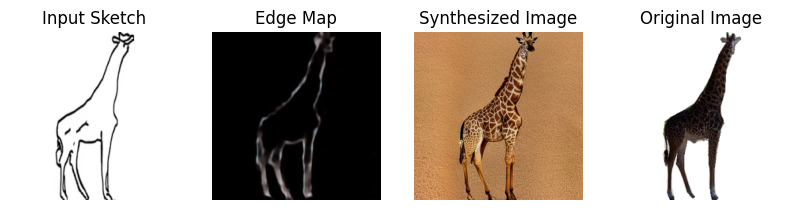

In [ ]:
sketch = dataset.get_sketch(sample_num)
target_image = dataset.get_target_image(sample_num)

for sketch, edge, image, traget in zip([sketch], latents_to_image(result.to(dtype)), latents_to_image(latents), [target_image]):

    gen_image = latents_to_image(latents)[0]

    metrics = evaluate_image_metrics(gen_image, target_image, device=device)

    print("Evaluation Results:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    fig, axs = plt.subplots(1, 4, figsize = (10, 5))
    axs[0].imshow(sketch)
    axs[1].imshow(edge)
    axs[2].imshow(image)
    axs[3].imshow(traget)
    axs[0].axis("off")
    axs[1].axis("off")
    axs[2].axis("off")
    axs[3].axis("off")
    axs[0].set_title("Input Sketch")
    axs[1].set_title("Edge Map")
    axs[2].set_title("Synthesized Image")
    axs[3].set_title("Original Image")

# UI

In [ ]:
%%capture
!pip install flask pyngrok flask-cors

In [ ]:
!ngrok config add-authtoken Your_Token

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import base64
import io
from PIL import Image
from torchvision import transforms

def generate(sketch):
    clf_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    predicted_class, confidence = predict_new_sketch(
        model=model,
        sketch=sketch,
        transform=clf_transform,
        classes=["giraffe", "zebra"],
        device=device
    )

    prompts = {
        "zebra": "a zebra in an empty savanna, dry grass plains, no trees, clear sky, minimalist nature, photorealistic",
        "giraffe": "a giraffe in an open barren plain, flat dry land, no vegetation, soft sunlight, isolated wildlife, high detail"
    }
    prompt = prompts[predicted_class]

    tensor_transform = transforms.ToTensor()
    sketch = tensor_transform(sketch)

    num_inference_timesteps = 50
    num_images_per_prompt = 1
    classifier_guidance_strength = 8
    sketch_guidance_strength = 1.4
    guidance_steps_perc = 0.5

    noise_scheduler.set_timesteps(num_inference_timesteps)
    batch_size = 1 if isinstance(prompt, str) else len(prompt)

    final_text_embeddings =  pipe._encode_prompt(
                prompt = prompt,
                device = device,
                num_images_per_prompt = num_images_per_prompt,
                do_classifier_free_guidance = True)

    encoded_edge_maps = prepare_sketch(prompt = prompt, num_images_per_prompt = num_images_per_prompt, sketch = sketch)
    gradient = True

    latents = torch.randn(
        batch_size * num_images_per_prompt,
        unet.config.in_channels,
        unet.config.sample_size,
        unet.config.sample_size,
        device=device,
        dtype=torch.float32
    ) * noise_scheduler.init_noise_sigma

    init_noise = latents.clone()

    for i, timestep in enumerate(tqdm.tqdm(noise_scheduler.timesteps)):

                gradient_state = torch.enable_grad()
                if i > int(guidance_steps_perc*num_inference_timesteps):
                    gradient_state = torch.no_grad()
                    gradient = False

                unet_input = noise_scheduler.scale_model_input(torch.cat([latents] * 2), timestep).to(device)
                unet_input = unet_input.requires_grad_(True)
                unet_input = unet_input.to(dtype)

                with gradient_state:
                    u, t = unet(unet_input, timestep, encoder_hidden_states = final_text_embeddings).sample.chunk(2)
                    pred = u + classifier_guidance_strength*(t-u)
                    del u, t
                    torch.cuda.empty_cache()

                latents_old = unet_input.chunk(2)[1]

                with torch.no_grad():
                  latents = noise_scheduler.step(pred, timestep, latents).prev_sample

                del pred
                torch.cuda.empty_cache()

                with gradient_state:
                        intermediate_result = []
                        for block in feature_blocks:
                            outputs = block.output
                            resized = F.interpolate(outputs, size = latents.shape[2], mode = "bilinear")
                            intermediate_result.append(resized)
                            del outputs, resized, block.output
                            torch.cuda.empty_cache()


                        intermediate_result = torch.cat(intermediate_result, dim=1).to(device)

                        noise_level = get_noise_level(init_noise, timestep)

                        result = RLEPUN(intermediate_result, torch.cat([noise_level]*2))
                        _, result = result.chunk(2)

                        if gradient:
                            similarity = torch.linalg.norm(result - encoded_edge_maps)**2

                            _, grad = torch.autograd.grad(similarity,  unet_input)[0].chunk(2)
                            alpha = (torch.linalg.norm(latents_old - latents)/torch.linalg.norm(grad))*sketch_guidance_strength

                            latents -= alpha*grad

                            del grad, similarity
                            torch.cuda.empty_cache()

                        del intermediate_result
                        torch.cuda.empty_cache()

                del unet_input, latents_old, result
                gc.collect()
                torch.cuda.empty_cache()
    return latents_to_image(latents)[0]

Note: Copy the link as in Public URL: NgrokTunnel: "https://bcc34925efb1.ngrok-free.app"

and past it on the \sketch-vision-ai\src\pages\Index.tsx as

    const response = await fetch("https://bcc34925efb1.ngrok-free.app/predict",


In [ ]:
import json
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok

app = Flask(__name__)

public_url = ngrok.connect(5000)
print("Public URL:", public_url)

CORS(app)

@app.route("/predict", methods=["POST"])
def predict():
    data = request.json
    image_data = data.get("image", "")

    if image_data.startswith("data:image"):
        image_data = image_data.split(",")[1]

    image_bytes = base64.b64decode(image_data)

    pil_image = Image.open(io.BytesIO(image_bytes))

    if pil_image.mode != "RGB":
      pil_image = pil_image.convert("RGB")

    generated_pil = generate(pil_image)

    buffer = io.BytesIO()
    generated_pil.save(buffer, format="PNG")
    generated_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")

    return jsonify({"generated_image": f"data:image/png;base64,{generated_base64}"})

app.run(port=5000)

Public URL: NgrokTunnel: "https://4a7fa5403155.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [12/Sep/2025 17:32:17] "OPTIONS /predict HTTP/1.1" 200 -
100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
INFO:werkzeug:127.0.0.1 - - [12/Sep/2025 17:33:20] "POST /predict HTTP/1.1" 200 -
